In [13]:
# Import necessary packages

import polars as pl
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [14]:
# Read data

df = pl.read_parquet("russell_3000_daily.parquet")

In [15]:
df

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,-0.788,55.056916,0.328385,0.34349,6.006157e8,121693.0,0.01
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,0.365,55.028021,0.334989,0.353329,6.0865392e8,131728.0,0.01
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,-0.731,54.807402,0.330713,0.363624,6.0769086e8,43252.0,0.01
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,1.936,54.76671,0.324494,0.356596,6.211737e8,70944.0,0.02
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,-0.528,54.692162,0.366323,0.399196,6.0576474e8,77085.0,0.01
…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.4261,1.121,20.842679,0.236481,0.302514,1.3226e8,31025.0,0.11
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.0414,2.305,20.954701,0.252015,0.29845,1.3231e8,6298.0,0.21
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,2.2351,0.213,21.480703,0.256752,0.31384,1.3527e8,26857.0,0.25


In [ ]:
def computeFactors(data: pl.DataFrame) -> pl.LazyFrame:
    """
    Compute factor signals (12m momentum, 1m mean reversion, simple BAB)
    and volatility-adjust them using Barra's specific_risk column.
    """
    # Convert date column if it's a string before creating lazy frame
    if data["date"].dtype == pl.Utf8:
        data = data.with_columns(pl.col("date").str.to_date())
    
    df = (
        data.lazy()
        .sort(["barrid", "date"])
        # --- Lagged price for filter ---
        .with_columns([
            pl.col("price").shift(1).over("barrid").alias("price_lagged"),
            (pl.col("return") / 100).alias("return_frac"),
            (pl.col("return") / 100).log1p().alias("log_return")
        ])
        .filter(pl.col("price_lagged") > 5)
        # --- 12-month momentum (t-12 to t-2) ---
        .with_columns([
            pl.col("log_return")
              .rolling_sum(window_size=252)
              .over("barrid")
              .alias("momentum_temp")
        ])
        .with_columns([
            pl.col("momentum_temp").shift(22).over("barrid").alias("momentum_12m")
        ])
        # --- 1-month mean reversion ---
        .with_columns([
            pl.col("return_frac")
              .rolling_sum(window_size=22)
              .over("barrid")
              .alias("meanrev_temp")
        ])
        .with_columns([
            (-pl.col("meanrev_temp").shift(1).over("barrid")).alias("meanrev_1m")
        ])
        # --- Simple BAB = -predicted_beta ---
        .with_columns([
            (-pl.col("predicted_beta")).alias("bab")
        ])
        # --- Vol adjustment using Barra's specific_risk ---
        .with_columns([
            (pl.col("momentum_12m") / pl.col("specific_risk")).alias("momentum_12m_voladj"),
            (pl.col("meanrev_1m") / pl.col("specific_risk")).alias("meanrev_1m_voladj"),
            (pl.col("bab") / pl.col("specific_risk")).alias("bab_voladj")
        ])
        # Keep all original columns and add only the vol-adjusted factors
        .drop(["momentum_temp", "meanrev_temp", "price_lagged", "return_frac", "log_return", "momentum_12m", "meanrev_1m", "bab"])  # Remove temporary and intermediate columns
    )
    return df

# computeFactors returns a LazyFrame
lazy_factors = computeFactors(df)

# trigger execution
factors = lazy_factors.collect()

factors

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread,momentum_12m_voladj,meanrev_1m_voladj,bab_voladj
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,0.365,55.028021,0.334989,0.353329,6.0865392e8,131728.0,0.01,null,null,-0.006421
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,-0.731,54.807402,0.330713,0.363624,6.0769086e8,43252.0,0.01,null,null,-0.006635
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,1.936,54.76671,0.324494,0.356596,6.211737e8,70944.0,0.02,null,null,-0.006511
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,-0.528,54.692162,0.366323,0.399196,6.0576474e8,77085.0,0.01,null,null,-0.007299
2013-08-07,"""USA06Z1""","""MDXG""",5.78,-8.1081,-7.74,55.020769,0.471876,0.504134,5.5664868e8,99609.0,0.01,null,null,-0.009163
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.4261,1.121,20.842679,0.236481,0.302514,1.3226e8,31025.0,0.11,null,-0.0028,-0.014514
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.0414,2.305,20.954701,0.252015,0.29845,1.3231e8,6298.0,0.21,null,-0.00049,-0.014243
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,2.2351,0.213,21.480703,0.256752,0.31384,1.3527e8,26857.0,0.25,null,-0.001066,-0.01461


In [19]:
def analyze_factor(data: pl.DataFrame, factor_col: str, factor_name: str):
    """Simple factor analysis with plots and Sharpe ratio."""
    
    # Create decile bins and portfolios
    portfolios = (
        data
        .filter(pl.col(factor_col).is_not_null())
        .with_columns(
            pl.col(factor_col).qcut(10, labels=[str(i) for i in range(10)]).over('date').alias('bin')
        )
        .group_by('date', 'bin')
        .agg(pl.col('return').mean())
        .pivot(index='date', on='bin', values='return')
        .sort('date')
        .with_columns((pl.col('9') - pl.col('0')).alias('spread'))
    )
    
    # Calculate cumulative returns
    cum_returns = (
        portfolios
        .unpivot(index='date', variable_name='bin', value_name='return')
        .filter(pl.col('return').is_not_null())
        .with_columns(
            (pl.col('return') / 100).log1p().cum_sum().over('bin').alias('cum_ret')
        )
        .sort('bin', 'date')
    )
    
    # Plot
    df_plot = cum_returns.to_pandas()
    plt.figure(figsize=(12, 6))
    
    for bin_num in ['0', '9', 'spread']:
        if bin_num in df_plot['bin'].values:
            data_subset = df_plot[df_plot['bin'] == bin_num]
            style = 'r--' if bin_num == 'spread' else '-'
            label = 'Long-Short' if bin_num == 'spread' else f'Decile {bin_num}'
            plt.plot(data_subset['date'], data_subset['cum_ret'] * 100, 
                    style, label=label, linewidth=2)
    
    plt.title(f'{factor_name} - Cumulative Returns')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Stats
    spread_data = portfolios.select(['spread']).filter(pl.col('spread').is_not_null())
    if len(spread_data) > 0:
        mean_ret = spread_data['spread'].mean()
        std_ret = spread_data['spread'].std()
        sharpe = mean_ret / std_ret * (252 ** 0.5)
        print(f"{factor_name}: Mean={mean_ret:.3f}%, Std={std_ret:.3f}%, Sharpe={sharpe:.2f}")

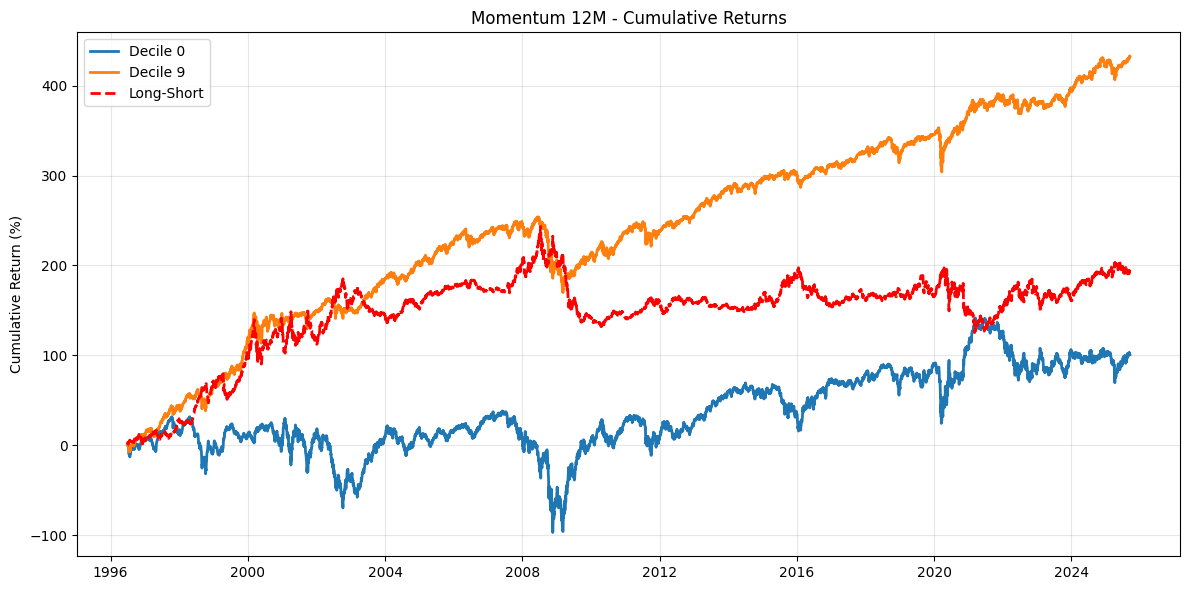

Momentum 12M: Mean=0.036%, Std=1.384%, Sharpe=0.42
----------------------------------------


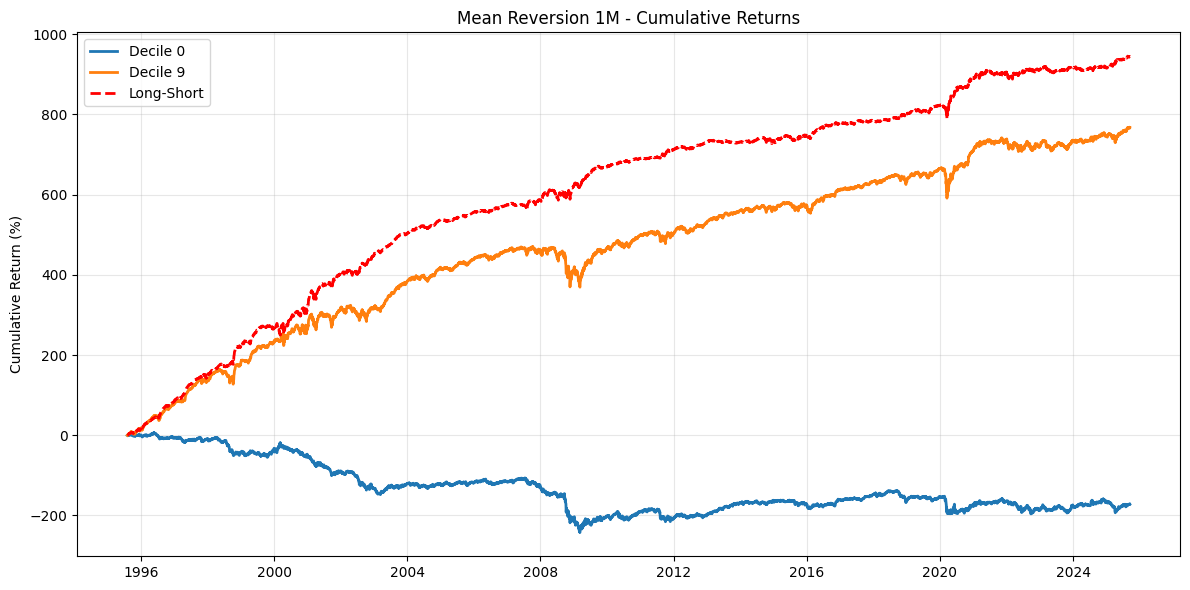

Mean Reversion 1M: Mean=0.131%, Std=1.136%, Sharpe=1.83
----------------------------------------


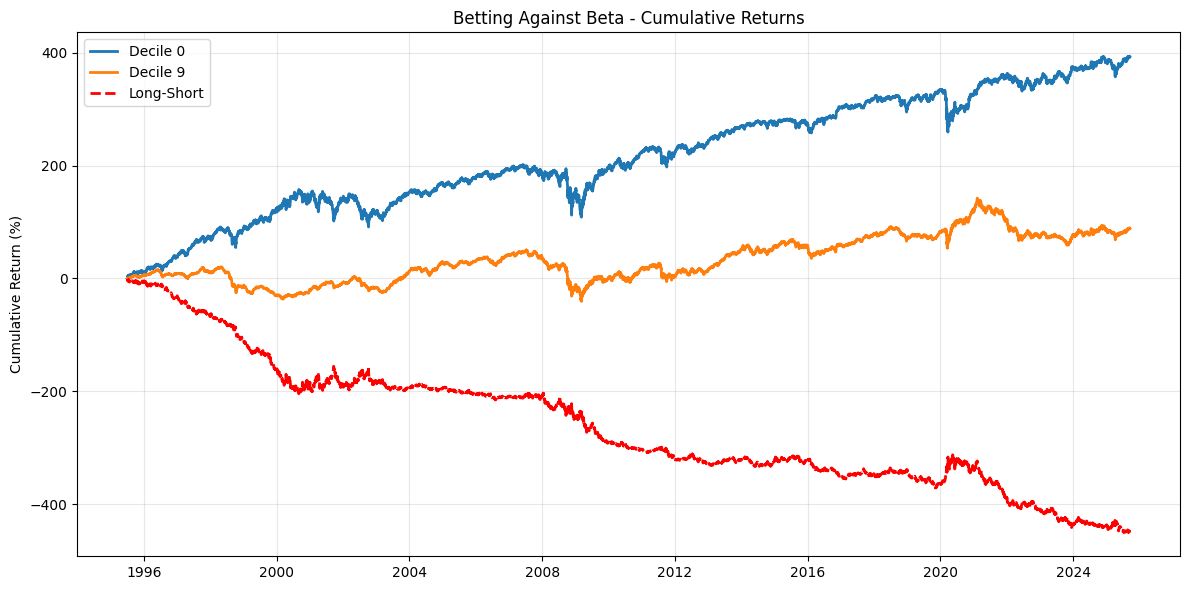

Betting Against Beta: Mean=-0.051%, Std=1.286%, Sharpe=-0.62
----------------------------------------


In [20]:
# Run analysis
factors_to_analyze = [
    ('momentum_12m_voladj', 'Momentum 12M'),
    ('meanrev_1m_voladj', 'Mean Reversion 1M'),
    ('bab_voladj', 'Betting Against Beta')
]

for factor_col, factor_name in factors_to_analyze:
    analyze_factor(factors, factor_col, factor_name)
    print("-" * 40)